<a href="https://colab.research.google.com/github/Muideen-Abubakar/P2P_Investment_Strategies/blob/main/P2P_Investment_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P2P Investment Strategy Assessment


In this exercise, I'll apply predictive modelling in building investment strategies. 

In forming training, validation, and testing set, I'll use only continuous features. I'm also assuming no short selling is allowed.

The weight of a selected loan in a portfolio is either zero or one, i.e. no partial weights are allowed.


# Provide all the necessary preliminaries such as importing libraries, dataset, etc.

In [ ]:
#Load the libraries 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1Ym9cuGKFBjlh_C31KZtnvQ9_Y7ykb9vt'}) # replace the id with id of file you want to access
downloaded.GetContentFile('clean_data_v2.pickle') 

In [ ]:
#Import the data
data, discrete_features, continuous_features = pickle.load(open('clean_data_v2.pickle', 'rb'))

In [ ]:
X_cont = continuous_features

X_cont

['loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'int_rate',
 'revol_util']

In [ ]:
#What the data looks like

data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,RENT,48000.0,...,5475.14000,2015-12-01,0.0,10.973531,36,0.031676,0.103917,0.031155,0.050634,0.086751
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,RENT,53000.0,...,20452.09912,2018-03-01,0.0,37.947391,36,0.067688,0.064215,0.050574,0.066334,0.094950
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,RENT,39000.0,...,9792.56000,2015-11-01,0.0,9.987885,36,0.029354,0.105803,0.029798,0.049345,0.085622
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,RENT,44000.0,...,16592.91130,2018-01-01,0.0,36.008953,36,0.061736,0.061721,0.047093,0.063007,0.091937
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,MORTGAGE,130000.0,...,15122.07997,2018-10-01,0.0,44.978336,60,0.102442,0.136655,0.113866,0.131897,0.164518


# Random Based Strategy

Here, I'm implementing the random based strategy, i.e. choose loans completely at random (uniform distribution), and build a portfolio made of these randomly chosen loans. 

I'll then calculate the average return (using the test dataset) of an investor if they use this strategy in long run. 

In this exercise, I'm using the following notions of returns ["return_1","return_2","return_3a","return_3b","return_3c"].

The number of iterations is set at 1000 and for each iteration I'll randomly select 100 loans from the test dataset. Based on this dataset and for each notion of return in ['return_1', 'return_2', 'return_3a', 'return_3b', 'return_3c'], we calculate the average returns that an investor might obtain following this random strategy.

Also, the dataset is split into training set, test set, and cross validation (though I didn't use the training and the cross validation set for this exercise): 60% training, 20% cross validation, and 20% testing. 

The goal is to estimate the average returns (using the test set) that an investor might obtain following this random based strategy.  

In [ ]:

#Return 1
data['return_1'] = ( (data.total_pymnt - data.funded_amnt) / data.funded_amnt ) * (12 / data['term_num'])

#Return 2
data['return_2'] = ( (data.total_pymnt - data.funded_amnt)/ data.funded_amnt ) * (12 / data['loan_length'])

#in the event that the loan takes a loss, we will modify the return based on the return_1
data.loc[data.return_2 < 0,'return_2'] = data.return_1[data.return_2 < 0]

#Compute return 3 by defining a function ret_method_3
def ret_method_3(data, T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (data.total_pymnt - data.recoveries) / data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, data.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - data['funded_amnt'] ) / data['funded_amnt'] ) )

#Calculating three different types of returns based on the ret_method_3
data['return_3a'] = ret_method_3(data, 5*12, 0.001)
data['return_3b'] = ret_method_3(data, 5*12, 0.0025)
data['return_3c'] = ret_method_3(data, 5*12, 0.005)


In [ ]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,return_1,return_2,return_3a,return_3b,return_3c
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,RENT,48000.0,...,0.031676,0.103917,0.031155,0.050634,0.086751,0.031676,0.103917,0.031155,0.050634,0.086751
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,RENT,53000.0,...,0.067688,0.064215,0.050574,0.066334,0.094950,0.067688,0.064215,0.050574,0.066334,0.094950
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,RENT,39000.0,...,0.029354,0.105803,0.029798,0.049345,0.085622,0.029354,0.105803,0.029798,0.049345,0.085622
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,RENT,44000.0,...,0.061736,0.061721,0.047093,0.063007,0.091937,0.061736,0.061721,0.047093,0.063007,0.091937
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,MORTGAGE,130000.0,...,0.102442,0.136655,0.113866,0.131897,0.164518,0.102442,0.136655,0.113866,0.131897,0.164518


In [ ]:
#Define a default random seed and an output file

default_seed = 1
output_file = "output_sample"
return_cols=["return_1","return_2","return_3a","return_3b","return_3c"]

X = data[continuous_features]
y = data[return_cols]

#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=default_seed)

#Split the train_set into train and Cross_validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=default_seed)

In [ ]:
sample_loans = y_test.sample(n=100, random_state = 1000)

sample_loans

,return_1,return_2,return_3a,return_3b,return_3c
225614,0.067212,0.065347,0.050391,0.066319,0.095256
486047,0.033369,0.048047,0.030610,0.047457,0.078322
569571,0.034222,0.107941,0.046226,0.065385,0.100656
880445,0.007696,0.094746,0.016838,0.036526,0.073313
37898,0.034897,0.059839,0.032033,0.049722,0.082235
...,...,...,...,...,...
83551,0.008803,0.063043,0.017314,0.036673,0.072771
146755,0.021008,0.125105,0.024952,0.044805,0.081788
488030,-0.122049,-0.122049,-0.117931,-0.111347,-0.099194
107624,0.066919,0.077593,0.050953,0.068090,0.099346


In [ ]:
#calculate the average return for ['return_1', 'return_2', 'return_3a', 'return_3b', 'return_3c']

#putting all return names in one list


print('The average returns obtainable based on the random strategy is:', '\n',pd.DataFrame(sample_loans.mean()))


The average returns obtainable based on the random strategy is: 
                   0
return_1   0.013028
return_2   0.050675
return_3a  0.017881
return_3b  0.034282
return_3c  0.064449


# Return Based Strategy

In this section, I implement a return based strategy, where I estimate the return of the loans (here using linear regression) and choose 100 loans with the highest return. More specifically, I'll use Ridge regression 

* The cross-validation step was skipped, and optimal alpha taken to be 240.




In [ ]:
#Define the Ridge model
model = Ridge(alpha=240)

#fit model
model.fit(X_train, y_train)

#Predict the returns
y1_pred = model.predict(X_test)

y1_pred = pd.DataFrame(index = np.array(X_test.index),data = y1_pred).set_axis(return_cols, axis =1)

y1_pred

,return_1,return_2,return_3a,return_3b,return_3c
161696,0.011056,0.040149,0.016086,0.031875,0.060848
418449,0.006596,0.031681,0.013309,0.029165,0.058298
412480,0.010720,0.039721,0.016059,0.032049,0.061422
233878,0.013998,0.037483,0.018749,0.034945,0.064696
506467,0.016340,0.039313,0.020446,0.036745,0.066681
...,...,...,...,...,...
281661,-0.001052,0.050051,0.006784,0.022605,0.051746
225947,-0.003656,0.050483,0.004257,0.019567,0.047726
915952,0.000859,0.047026,0.009807,0.026472,0.057255
522827,0.022068,0.035756,0.024845,0.041218,0.071254


In [ ]:
top_100 = pd.DataFrame([])

for i in y1_pred.columns:
    col = pd.DataFrame(y1_pred[i].nlargest(100))
    col = col.reset_index(drop = True)
    top_100 = pd.concat([top_100, col], axis =1)
    
top_100

,return_1,return_2,return_3a,return_3b,return_3c
0,0.090120,0.418263,0.087638,0.118458,0.181986
1,0.082074,0.403728,0.084909,0.117310,0.177340
2,0.078816,0.309308,0.082312,0.115170,0.173096
3,0.070412,0.226571,0.066935,0.092275,0.139677
4,0.068223,0.223764,0.063550,0.084887,0.127883
...,...,...,...,...,...
95,0.036290,0.087360,0.036097,0.053700,0.086323
96,0.036281,0.087281,0.036082,0.053629,0.086257
97,0.036242,0.087140,0.036071,0.053385,0.086162
98,0.036193,0.087056,0.035995,0.053330,0.086151


In [ ]:
print('The average returns obtainable based on the return-based strategy is:', '\n',top_100.mean())

The average returns obtainable based on the return-based strategy is: 
 return_1     0.044228
return_2     0.119689
return_3a    0.043683
return_3b    0.062932
return_3c    0.098664
dtype: float64



Here, I'll use a neural network with two hidden layers.
* Cross validation was skipped  


In [ ]:
scale = StandardScaler()

scale.fit(X_train, y_train)

#Standardize data
X_train_scale = scale.transform(X_train)
X_test_scale = scale.transform(X_test)

n_features, n_outputs = X_train.shape[1],5

In [ ]:
#Print the input and output layer dimension
print(n_features)
print(n_outputs)
print(X_train.shape)

13
5
(363224, 13)


In [ ]:
#initializer = tf.keras.initializers.TruncatedNormal(seed = default_seed)
initializer = tf.keras.initializers.RandomNormal(seed = default_seed)


#We setup the layers
model = Sequential()
model.add(Dense(100, input_dim = n_features, kernel_initializer = initializer, activation = 'linear'))
model.add(Dense(100, input_dim = n_features, kernel_initializer = initializer, activation = 'linear'))
#Set up the output layer
model.add(Dense(n_outputs, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'MSE', metrics = ['accuracy'])
loss_accuracy_history = model.fit(X_train_scale, y_train.values, epochs = 500, batch_size = 20000, verbose = 2 )

Epoch 1/500
19/19 - 2s - loss: 0.0087 - accuracy: 0.4516 - 2s/epoch - 92ms/step
Epoch 2/500
19/19 - 1s - loss: 0.0064 - accuracy: 0.6275 - 810ms/epoch - 43ms/step
Epoch 3/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6886 - 810ms/epoch - 43ms/step
Epoch 4/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6913 - 791ms/epoch - 42ms/step
Epoch 5/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6924 - 789ms/epoch - 42ms/step
Epoch 6/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6927 - 781ms/epoch - 41ms/step
Epoch 7/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6921 - 791ms/epoch - 42ms/step
Epoch 8/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6924 - 804ms/epoch - 42ms/step
Epoch 9/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6924 - 802ms/epoch - 42ms/step
Epoch 10/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6926 - 789ms/epoch - 42ms/step
Epoch 11/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6923 - 795ms/epoch - 42ms/step
Epoch 12/500
19/19 - 1s - loss: 0.0062 - accuracy: 0.6923 - 799ms/epoch - 42ms/step
Epoc

In [ ]:
#print predicted returns
y2_pred = pd.DataFrame(model.predict(X_test_scale), index = X_test.index).set_axis(return_cols, axis =1)

y2_pred

,return_1,return_2,return_3a,return_3b,return_3c
161696,0.011855,0.039603,0.015353,0.032099,0.060105
418449,0.006939,0.032451,0.012416,0.029213,0.057623
412480,0.011631,0.038780,0.014956,0.032050,0.060407
233878,0.015002,0.036436,0.017438,0.034878,0.063782
506467,0.017047,0.038380,0.019061,0.036649,0.065584
...,...,...,...,...,...
281661,0.000551,0.049162,0.006624,0.022415,0.050549
225947,-0.001898,0.049701,0.004475,0.019482,0.046689
915952,0.001428,0.046860,0.010188,0.026875,0.056990
522827,0.022523,0.035577,0.024109,0.041328,0.071029


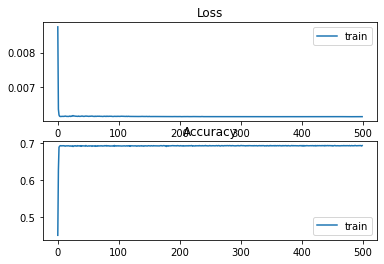

In [ ]:
#Plot the loss and accuracy 
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(loss_accuracy_history.history['loss'], label='train')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(loss_accuracy_history.history['accuracy'], label = 'train')
pyplot.legend()
pyplot.show()

In [ ]:
#Get the top 100 returns in descending order
NN_top_100 = pd.DataFrame([])

for j in y2_pred.columns:
    NN_col = pd.DataFrame(y2_pred[j].nlargest(100))
    NN_col = NN_col.reset_index(drop = True)
    NN_top_100 = pd.concat([NN_top_100, NN_col], axis =1)
    
NN_top_100

,return_1,return_2,return_3a,return_3b,return_3c
0,0.094996,0.383011,0.118747,0.134893,0.198543
1,0.089640,0.370453,0.113171,0.130866,0.191876
2,0.085343,0.282748,0.110757,0.129524,0.185147
3,0.071355,0.208701,0.081821,0.100370,0.147160
4,0.068187,0.205379,0.071400,0.089478,0.134461
...,...,...,...,...,...
95,0.036627,0.085451,0.037793,0.054414,0.087258
96,0.036554,0.085408,0.037747,0.054366,0.087253
97,0.036526,0.085250,0.037710,0.054323,0.087170
98,0.036517,0.085195,0.037702,0.054304,0.087098


In [ ]:
print('The average return based using Neural Network for the return-based strategy is:', '\n', NN_top_100.mean())

The average return based using Neural Network for the return-based strategy is: 
 return_1     0.044465
return_2     0.115402
return_3a    0.048316
return_3b    0.064957
return_3c    0.100788
dtype: float32


# Default Based Strategy

Here, I'll implement a default based strategy, i.e. to select 100 loans with the highest credit quality (a loan with Probility of Default (PD) of zero has the highest credit quality)

I trained three different machine learning models to estimate the probability of default for these loans. 
* Cross validation step skipped 


In [ ]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Default'], dtype=object)

In [ ]:
y = data.loan_status.isin(["Charged Off", "Default"]).values

In [ ]:
continuous_data = data[X_cont]
return_data = data[return_cols]

data_1 = pd.concat([continuous_data,return_data], axis =1)

data_1.head()

,loan_amnt,funded_amnt,installment,annual_inc,dti,revol_bal,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,int_rate,revol_util,return_1,return_2,return_3a,return_3b,return_3c
0,5000.0,5000.0,167.01,48000.0,14.25,5994.0,0.0,7.0,0.0,674.0,670.0,12.39,44.4,0.031676,0.103917,0.031155,0.050634,0.086751
2,17000.0,17000.0,567.82,53000.0,21.31,14690.0,0.0,12.0,0.0,684.0,680.0,12.39,73.1,0.067688,0.064215,0.050574,0.066334,0.094950
3,9000.0,9000.0,308.96,39000.0,24.80,26172.0,0.0,10.0,0.0,719.0,715.0,14.31,77.7,0.029354,0.105803,0.029798,0.049345,0.085622
4,14000.0,14000.0,464.94,44000.0,18.41,14330.0,0.0,11.0,0.0,664.0,660.0,11.99,34.8,0.061736,0.061721,0.047093,0.063007,0.091937
5,10000.0,10000.0,260.73,130000.0,13.73,5947.0,0.0,12.0,0.0,709.0,705.0,19.24,44.1,0.102442,0.136655,0.113866,0.131897,0.164518


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_1, y, test_size = 0.4, random_state = default_seed)
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size = 0.5, random_state = default_seed)

scale = StandardScaler()

scale.fit(X_train, y_train)

X_train_scale = scale.transform(X_train)
X_test_scale = scale.transform(X_test)

In [ ]:
#Using a Tree Model

clf_tree = DecisionTreeClassifier(min_samples_leaf = 6, max_depth = 6, min_samples_split = 10, random_state = default_seed)
#fit the model
tree_model = clf_tree.fit(X_train_scale, y_train)

#predict probability of default
tree_score = pd.DataFrame(tree_model.predict_proba(X_test_scale), index = X_test.index)

#title the columns
col_names = ['Prob of Survival', 'Prob of Default']
tree_score.columns = col_names

#Sort the top 100 based on highest probability of survival (lowest prob of default)
good_qlty_tree = tree_score.sort_values(by = 'Prob of Survival', ascending = False).head(100)

#Get the index of the top 100 good quality loans
index = good_qlty_tree.index

#match the index with the loans and sort index in asc order
good_loans_tree = data_1.filter(items = index, axis = 0).sort_index()

#Get the mean return for each notion of return
print('The average returns based on the top 100 quality loans are: ', '\n',good_loans_tree[return_cols].mean())

The average returns based on the top 100 quality loans are:  
 return_1     0.024868
return_2     0.035261
return_3a    0.024839
return_3b    0.040604
return_3c    0.069452
dtype: float64


In [ ]:
#Logit Model

clf_logit = LogisticRegression(penalty = 'l2', C = 1, random_state = default_seed, max_iter = 1000)
logit_model = clf_logit.fit(X_train_scale, y_train)

logit_score = pd.DataFrame(clf_logit.predict_proba(X_test_scale), index = X_test.index)

#Title the columns
logit_score.columns = col_names

#Sort the top 100 based on highest probability of survival (lowest prob of default)
good_qlty_logit = logit_score.sort_values(by = 'Prob of Default', ascending = True).head(100)

#Get the index of the top 100 good quality loans
index_logit = good_qlty_logit.index

good_loans_logit = data_1.filter(items = index_logit, axis = 0).sort_index()

good_loans_logit[return_cols]
#Get the mean return for each notion of return
#print('The average returns based on the top 100 quality loans are: ', '\n',good_loans_logit[return_cols].mean())


,return_1,return_2,return_3a,return_3b,return_3c
5886,0.118533,0.209146,0.132371,0.154298,0.194209
11910,0.115702,0.210455,0.129583,0.151590,0.191672
12101,0.108580,0.210277,0.122470,0.144508,0.184703
13404,0.150951,0.188685,0.163662,0.183708,0.219930
15817,0.101766,0.226365,0.115977,0.138569,0.179895
...,...,...,...,...,...
581880,0.118229,0.215265,0.132227,0.154418,0.194838
582303,0.140823,0.256403,0.155815,0.179581,0.222871
583539,0.098214,0.226751,0.112412,0.134992,0.176328
768312,0.021565,0.387367,0.025654,0.046139,0.084412


In [ ]:
good_qlty_logit

,Prob of Survival,Prob of Default
48387,1.0,1.121723e-23
492877,1.0,4.823007e-11
917505,1.0,8.803821e-11
261258,1.0,1.607382e-10
582303,1.0,7.206006e-10
...,...,...
261903,1.0,2.425071e-08
261325,1.0,2.454913e-08
460225,1.0,2.465912e-08
52088,1.0,2.474232e-08


In [ ]:
logit_score

,Prob of Survival,Prob of Default
198717,0.000000e+00,1.000000
426375,9.996574e-01,0.000343
98543,9.868631e-01,0.013137
703875,9.999177e-01,0.000082
634385,9.987970e-01,0.001203
...,...,...
415005,4.207745e-13,1.000000
1033725,9.999447e-01,0.000055
135865,9.999908e-01,0.000009
550228,1.756211e-10,1.000000


In [ ]:
#Random Forest model
clf_RF = RandomForestClassifier(criterion = 'entropy', random_state = default_seed)
RF_model = clf_RF.fit(X_train_scale, y_train)

RF_score = pd.DataFrame(clf_RF.predict_proba(X_test_scale), index = X_test.index)
RF_score.columns = col_names
good_qlty_RF = RF_score.sort_values(by = 'Prob of Survival', ascending = False).head(100)
index_RF = good_qlty_RF.index
good_loans_RF = data_1.filter(items = index_RF, axis = 0).sort_index()


#Get the mean return for each notion of return
print('The average returns based on the top 100 quality loans are: ', '\n',good_loans_RF[return_cols].mean())


The average returns based on the top 100 quality loans are:  
 return_1     0.046902
return_2     0.090389
return_3a    0.042051
return_3b    0.060222
return_3c    0.093638
dtype: float64


# Comparison of the different strategies and models

Of the three strategies, the most appealing is the Default strategy sepcifically for two reason; 
1. It shows us the loans with the highest quality, hence minimising our risk
2. The Logistic regression used under the Default strategy also resulted in the highest set of returns compared to the other strategies.

As such, being a rational investor, loans with the highest quallity and comparatively high returns will be more attractive. 